Import from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !apt-get install tree

In [ ]:
# !tree /content/drive/MyDrive/image_class_task_dataset

Random set up - for repeated work will use different notebook for other models

In [14]:
import torch
import numpy as np
import random
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import gc

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # cuda
    torch.backends.cudnn.benchmark = False  # ensure repeated result for restart session

In [4]:
seed = 42
set_seed(seed)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #as pre-train used
])

In [6]:
data_dir = '/content/drive/MyDrive/image_class_task_dataset'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
valid_dataset = datasets.ImageFolder(root=f'{data_dir}/valid', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

In [7]:
def train_and_validate(model, criterion, optimizer, train_loader, valid_loader, scheduler=None,
                       num_epochs=50, grad_clip=None, device='cpu'):
    """
    reocrd changes in loss and acc
    """
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # average loss and acc per whole dataset
        train_loss = running_loss / total_train
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # validation step
        model.eval()
        valid_loss, correct_valid, total_valid = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_valid += (preds == labels).sum().item()
                total_valid += labels.size(0)

        # as above
        valid_loss /= total_valid
        valid_acc = 100 * correct_valid / total_valid
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        # print current progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_acc:.2f}%")

        # change lr if have
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(valid_loss)  # Pass validation loss for ReduceLROnPlateau
            else:
                scheduler.step()  # Step for other scheduler types

    return history

In [15]:
batch_size = 32
learning_rate = 1e-3
model_type = 'alexnet'
optimizer_type = 'Adam'
schedulers = ['ReduceLROnPlateau']

In [16]:
set_seed(42)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_loader.dataset.classes)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
experiment_results_alexnet_1 = []

In [20]:
for sched in schedulers:

        # Release RAM
        torch.cuda.empty_cache()
        gc.collect()

        # Set seed for reproducibility
        set_seed(42)

        # Initialize AlexNet model
        model = models.alexnet(pretrained=True)
        num_ftrs = model.classifier[6].in_features

        # Modify the classifier of AlexNet
        model.classifier[0] = nn.Dropout(0.3)
        model.classifier[3] = nn.Dropout(0.3)

        # Modify the final layer to match the number of classes
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

        # Freeze all layers except the last classifier layer
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True

        # Move the model to the specified device
        model = model.to(device)
        # Define loss function
        criterion = nn.CrossEntropyLoss()

        # Define optimizer as Adam
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Define scheduler
        if sched == 'CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
        elif sched == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
        else:
            scheduler = None

        # Print current configuration
        print(f"\nTraining {model_type} with Batch Size={batch_size}, LR={learning_rate}, "
              f"Optimizer={optimizer_type}, Scheduler={sched}\n")

        # Train and validate
        history = train_and_validate(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader=train_loader,
            valid_loader=valid_loader,
            scheduler=scheduler,
            num_epochs=100,
            grad_clip=1.0,
            device=device
        )

        # Record results
        experiment_results_alexnet_1.append({
            'model_type': model_type,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer_type': optimizer_type,
            'scheduler': sched,
            'dropout': 0.3,
            'grad_clip': 1.0,
            'history': history
        })

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 206MB/s]



Training alexnet with Batch Size=32, LR=0.001, Optimizer=Adam, Scheduler=ReduceLROnPlateau

Epoch [1/100], Train Loss: 1.1793, Train Acc: 45.07%, Valid Loss: 0.8837, Valid Acc: 58.54%
Epoch [2/100], Train Loss: 0.7709, Train Acc: 73.24%, Valid Loss: 0.5618, Valid Acc: 80.49%
Epoch [3/100], Train Loss: 0.6058, Train Acc: 76.76%, Valid Loss: 0.4812, Valid Acc: 80.49%
Epoch [4/100], Train Loss: 0.3726, Train Acc: 85.92%, Valid Loss: 0.3877, Valid Acc: 90.24%
Epoch [5/100], Train Loss: 0.4187, Train Acc: 84.51%, Valid Loss: 0.4480, Valid Acc: 82.93%
Epoch [6/100], Train Loss: 0.3664, Train Acc: 87.32%, Valid Loss: 0.3366, Valid Acc: 87.80%
Epoch [7/100], Train Loss: 0.2861, Train Acc: 90.85%, Valid Loss: 0.2796, Valid Acc: 87.80%
Epoch [8/100], Train Loss: 0.2422, Train Acc: 91.55%, Valid Loss: 0.3293, Valid Acc: 87.80%
Epoch [9/100], Train Loss: 0.2073, Train Acc: 93.66%, Valid Loss: 0.2940, Valid Acc: 85.37%
Epoch [10/100], Train Loss: 0.2572, Train Acc: 90.14%, Valid Loss: 0.2956, Vali

In [22]:
import pandas as pd

In [23]:
experiment_df_alex_1 = pd.DataFrame([
    {
        'model_type': result['model_type'],
        'batch_size': result['batch_size'],
        'learning_rate': result['learning_rate'],
        'optimizer_type': result['optimizer_type'],
        'scheduler': result['scheduler'],
        'dropout': 0.3,
        'grad_clip:': 1.0,
        'train_loss': result['history']['train_loss'],
        'valid_loss': result['history']['valid_loss'],
        'train_acc': result['history']['train_acc'],
        'valid_acc': result['history']['valid_acc']
    }
    for result in experiment_results_alexnet_1
])

In [25]:
# expand per epch result
experiment_df_alex_1.to_csv("experiment_results_res.csv", index=False)
print("Experiment results have been saved to experiment_results.csv")

Experiment results have been saved to experiment_results.csv


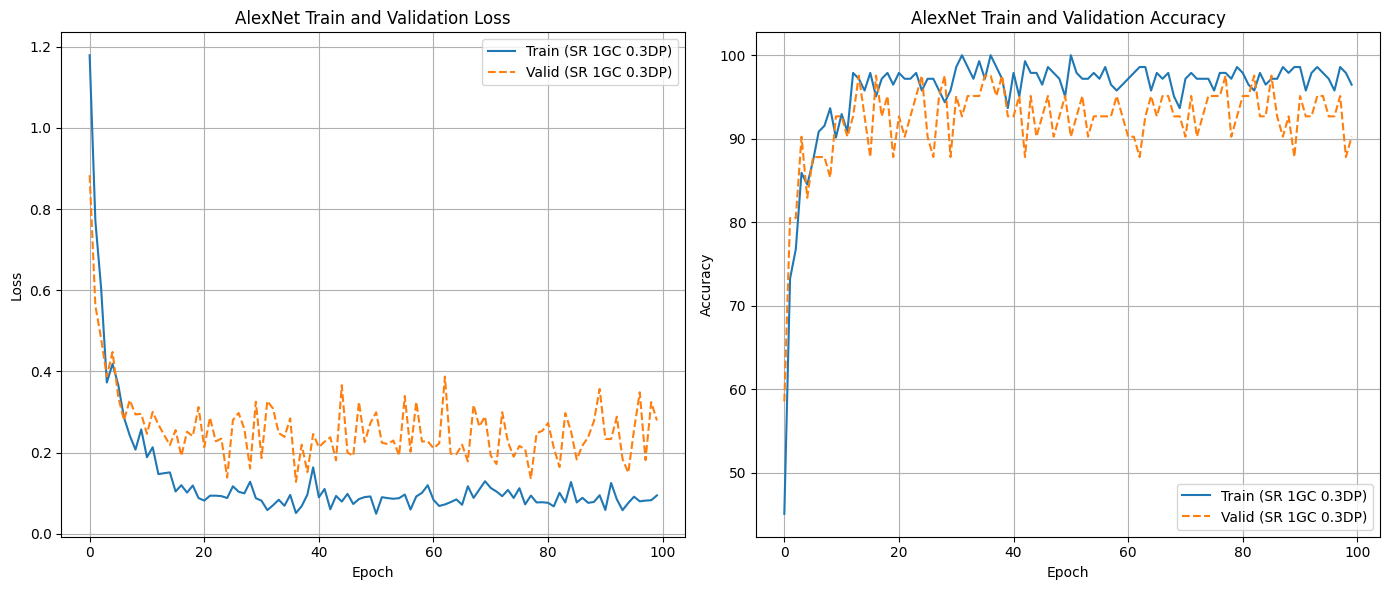

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define the mapping with default values
scheduler_map = {'CosineAnnealingLR': 'SC', 'ReduceLROnPlateau': 'SR'}
grad_clip_map = {'False': 'NoGC', 1.0: '1GC'}
dropout_map = {'False': 'NoDP', 0.3: '0.3DP'}

# Plot train and validation Loss
for i, row in experiment_df_alex_1.iterrows():
    scheduler = scheduler_map.get(row.get('scheduler', 'SC'), 'SC')
    grad_clip = grad_clip_map.get(row.get('grad_clip:', 'NoGC'), 'NoGC')
    dropout = dropout_map.get(row.get('dropout', 'NoDP'), 'NoDP')

    label = f"{scheduler} {grad_clip} {dropout}"

    ax1.plot(row['train_loss'], label=f"Train ({label})", linestyle='-')
    ax1.plot(row['valid_loss'], label=f"Valid ({label})", linestyle='--')

ax1.set_title("AlexNet Train and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot train and validation accuracy
for i, row in experiment_df_alex_1.iterrows():
    scheduler = scheduler_map.get(row.get('scheduler', 'SC'), 'SC')
    grad_clip = grad_clip_map.get(row.get('grad_clip:', 'NoGC'), 'NoGC')
    dropout = dropout_map.get(row.get('dropout', 'NoDP'), 'NoDP')

    label = f"{scheduler} {grad_clip} {dropout}"

    ax2.plot(row['train_acc'], label=f"Train ({label})", linestyle='-')
    ax2.plot(row['valid_acc'], label=f"Valid ({label})", linestyle='--')

ax2.set_title("AlexNet Train and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()